---
# Word2Vec with Python

---

Google's Word2Vec is a deep-learning inspired method that focuses on the meaning of words. Word2Vec attempts to understand meaning and semantic relationships among words. It works in a way that is similar to deep approaches, such as recurrent neural nets or deep neural nets, but is computationally more efficient.

The Word2Vec tool takes a text corpus as input and produces the word vectors as output. It first constructs a vocabulary from the training text data and then learns vector representation of words. The resulting word vector file can be used as features in many natural language processing and machine learning applications. Word2Vec does not need labels in order to create meaningful representations. This is useful, since most data in the real world is unlabeled. If the network is given enough training data (tens of billions of words), it produces word vectors with intriguing characteristics. Words with similar meanings appear in clusters, and clusters are spaced such that some word relationships, such as analogies, can be reproduced using vector math. The most famous examples of highly trained word vectors are `"king - man + woman = queen"` and `"Paris - France + Italy = Rome"`.
 
In Python, we will use the excellent implementation of Word2Vec from the [`gensim` package](https://pypi.python.org/pypi/gensim). If you don't alread y have gensim installed, you'll need to install it using pip

    pip install gensim
    
Although Word2Vec does not require graphics processing units (GPUs) like many deep learning algorithms, it is compute intensive. Both Google's version and the Python version rely on multi-threading (running multiple processes in parallel on your computer to save time). In order to train your model in a reasonable amount of time, you will need to install `cython` (instructions [here](http://docs.cython.org/src/quickstart/install.html)). Word2Vec will run without `cython` installed, but it will take days to run instead of minutes.

## 1. Dataset reading

In this lesson, we will use a dataset for binary sentiment classification containing users reviews for movies from IMDb web site. You need download the dataset called <u><span style="color: red">movie.zip (81.1Mb)</span></u> from [http://www.cs.cornell.edu](http://www.cs.cornell.edu/people/pabo/movie-review-data/) web site. It contains about 28,000 reviews in HTML format. 

After downloading the zip file unzip it in the folder with the current IPython notebook.

Let's look at the conent of the some HTML file containg reviews to some movie. To parse HTML format and extract data between HTML tags we will use [`BeautifulSoup` Python library](http://www.crummy.com/software/BeautifulSoup/) wich we have used earlier.

In [1]:
from bs4 import BeautifulSoup

# Read HTML file
with open('polarity_html/movie/0002.html') as f:
    html = f.read()
# Create a new BeautifulSoup instance
soup = BeautifulSoup(html)
# Display HTML file content if a prettified format
print soup.prettify()

<html>
 <head>
  <title>
   Review for Hitcher, The (1986)
  </title>
  <link href="/ramr.css" rel="STYLESHEET" type="text/css"/>
 </head>
 <body bgcolor="#FFFFFF" text="#000000">
  <h1 align="CENTER" class="title">
   <a href="/Title?0091209">
    Hitcher, The (1986)
   </a>
  </h1>
  <h3 align="CENTER">
   reviewed by
   <br/>
   <a href="/ReviewsBy?Mark+R.+Leeper">
    Mark R. Leeper
   </a>
  </h3>
  <hr size="4" width="40%"/>
  <p>
   [Editor's note: Sites running 2.10 netnews will munge headers of articles in
moderated  groups *not* named mod.something.  If you get my name instead of
Mark Leeper's in the "From:" line, please encourage your S.A. and your feed's
S.A. to upgrade to 2.11.  Thank you.  And now, on to our review... -ecl]
  </p>
  <pre>                                 THE HITCHER
                       A film review by Mark R. Leeper
                        Copyright 1987 Mark R. Leeper</pre>
  <p>
   Capsule review:  Boring actioner about a psychotic
     hitchhiker wh

As you can see, each users review is wrapped in `<p>` HTML tag, but there are also some `<p>` tags with helpfull information, so we should miss them. But we can also see that `<p>` tags necessary for us are positioned after the first `<pre>` tag and before the last one. The similar content have all other HTML files with reviews (please check it). Thus, we will remain only those HTML text which is placed between these `<pre>` tags.

In [2]:
# HTML tags (including <pre></pre>) are written uppercase in dataset's files
soup = BeautifulSoup(' '.join(html.split('</PRE>')[1:-1]))
print soup.prettify()

<html>
 <body>
  <p>
   Capsule review:  Boring actioner about a psychotic
     hitchhiker whom the scriptwriter makes unkillable.
     Contrived, unbelievable, and ultimately dull thriller is one
     more film to waste Rutger Hauer.
  </p>
  <p>
   You want a thriller with lots of mindless action, no logic, and a bunch
of fractional-dimensional characters.  Cable this month is running what
passes for entertainment in some quarters.  The film is THE HITCHER and as a
friend of mine would say, it sucks pond water.  Actually I think this one
could turn back a raging river.
  </p>
  <p>
   Our main character--I don't think we ever get his name so I will call
him Poor Schnook--is a teenager driving a car from Chicago to San Diego by
way of nearly empty Texas roads.  Schnook picks up a psychotic killer played
by Rutger Hauer, who adds one more implacable killer to his list of roles.
Hauer had better start being more selective in his roles or he will lose the
aura he had from SOLDIER OF ORAN

Now we can get text of reviews using [`findAll`](http://www.crummy.com/software/BeautifulSoup/bs4/doc/#find-all) method.

In [3]:
for num, i in enumerate(soup.findAll('p')):
    print num, '\n', i.text

0 
          Capsule review:  Boring actioner about a psychotic
     hitchhiker whom the scriptwriter makes unkillable.
     Contrived, unbelievable, and ultimately dull thriller is one
     more film to waste Rutger Hauer.
1 
     You want a thriller with lots of mindless action, no logic, and a bunch
of fractional-dimensional characters.  Cable this month is running what
passes for entertainment in some quarters.  The film is THE HITCHER and as a
friend of mine would say, it sucks pond water.  Actually I think this one
could turn back a raging river.
2 
     Our main character--I don't think we ever get his name so I will call
him Poor Schnook--is a teenager driving a car from Chicago to San Diego by
way of nearly empty Texas roads.  Schnook picks up a psychotic killer played
by Rutger Hauer, who adds one more implacable killer to his list of roles.
Hauer had better start being more selective in his roles or he will lose the
aura he had from SOLDIER OF ORANGE and BLADERUNNER.  From t

## 2. Bag-of-words mode of text representation

Now we can get text of reviews from one HTML file and process then, but how do we convert them to some kind of numeric representation for machine learning, particularly, for text classification as good or bad review or for prediction of which movie was devoted the comment for? One common approach is called a **Bag-of-words**. The Bag-of-words model learns a vocabulary from all of the documents, then models each document by counting the number of times each word appears. For example, consider the following two sentences:

    Sentence 1: "The cat sat on the hat"

    Sentence 2: "The dog ate the cat and the hat"

From these two sentences, our vocabulary is as follows:

    { the, cat, sat, on, hat, dog, ate, and }

To get our bags of words, we count the number of times each word occurs in each sentence. In `Sentence 1`, "the" appears twice, and "cat", "sat", "on", and "hat" each appear once, so the feature vector for `Sentence 1` is:

    { the, cat, sat, on, hat, dog, ate, and }

    Sentence 1: { 2, 1, 1, 1, 1, 0, 0, 0 }

Similarly, the features for `Sentence 2` are: 

    Sentence 2: { 3, 1, 0, 0, 1, 1, 1, 1}
    
<img src="images/bag-of-words.png" width=75%>
    
This vector representation does not preserve the order of the words in the original sentences. This kind of representation has several successful applications, for example email filtering.

We'll be using the `feature_extraction` module from `scikit-learn` to create Bag-of-words features. If you have not `scikit-learn` installed, read [this](http://scikit-learn.org/stable/install.html) instruction.

Before, we need to split a paragraph into sentences. There are all kinds of gotchas in natural language. English sentences can end with "?", "!", """, or ".", among other things, and spacing and capitalization are not reliable guides either. For this reason, we'll use the Python [Natural Language Toolkit](http://www.nltk.org)'s punkt tokenizer for sentence splitting.  You'll need to [install](http://www.nltk.org/install.html) the library if you don't already have it on your computer

In [4]:
import nltk
from nltk.tokenize import sent_tokenize

In [5]:
import re

text = ''
for i in soup.findAll('p'):
    text += ' ' + i.text

# Lowercase text, remove "\n" symbols
text = text.lower().replace('\n', ' ').strip()
    
sentences = sent_tokenize(text)
# Remove non-letters  
sentences = map(lambda x: re.sub("[^a-zA-Z]", " ", x).strip(), sentences)  
# Remove extra spaces (it isn't required)
for i in range(len(sentences)):
    while ' '*2 in sentences[i]:
        sentences[i] = sentences[i].replace(' '*2, ' ')
        
print len(sentences)
sentences

22


[u'capsule review boring actioner about a psychotic hitchhiker whom the scriptwriter makes unkillable',
 u'contrived unbelievable and ultimately dull thriller is one more film to waste rutger hauer',
 u'you want a thriller with lots of mindless action no logic and a bunch of fractional dimensional characters',
 u'cable this month is running what passes for entertainment in some quarters',
 u'the film is the hitcher and as a friend of mine would say it sucks pond water',
 u'actually i think this one could turn back a raging river',
 u'our main character i don t think we ever get his name so i will call him poor schnook is a teenager driving a car from chicago to san diego by way of nearly empty texas roads',
 u'schnook picks up a psychotic killer played by rutger hauer who adds one more implacable killer to his list of roles',
 u'hauer had better start being more selective in his roles or he will lose the aura he had from soldier of orange and bladerunner',
 u'from the point he gets pic

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Creating the bag-of-words
vectorizer = CountVectorizer()

# fit_transform() does two functions: First, it fits the model and learns the vocabulary; 
# second, it transforms our training data into feature vectors. 
# The input to fit_transform should be a list of strings.
data_features = vectorizer.fit_transform(sentences)

# Look at the collection of all words in `sentences`
print "Unique words ({}):".format(len(vectorizer.get_feature_names()))
print vectorizer.get_feature_names()

Unique words (225):
[u'about', u'action', u'actioner', u'actually', u'adds', u'aftermath', u'against', u'always', u'an', u'and', u'another', u'apparently', u'are', u'as', u'at', u'audiences', u'aura', u'back', u'basic', u'be', u'before', u'being', u'better', u'bladerunner', u'boring', u'bullet', u'bunch', u'but', u'by', u'bystander', u'cable', u'call', u'can', u'capsule', u'car', u'carefully', u'cars', u'character', u'characters', u'chicago', u'choreographed', u'claims', u'contrived', u'could', u'destruction', u'diego', u'dimensional', u'does', u'don', u'done', u'driving', u'dropping', u'dull', u'else', u'empty', u'engine', u'entertainment', u'entire', u'equivalent', u'ever', u'everything', u'fall', u'film', u'for', u'fractional', u'friend', u'from', u'get', u'gets', u'getting', u'gives', u'had', u'has', u'hauer', u'have', u'he', u'head', u'hear', u'hearing', u'helicopter', u'him', u'his', u'hitcher', u'hitchhiker', u'implacable', u'important', u'in', u'innocent', u'instant', u'instead

In [7]:
# Numpy arrays are easy to work with, so convert the result to an array
data_features = data_features.toarray()

print "Data features size:", data_features.shape
print "Vector representation of sentences:\n"
for num, vec in enumerate(data_features):
    print sentences[num], '\n', vec

Data features size: (22, 225)
Vector representation of sentences:

capsule review boring actioner about a psychotic hitchhiker whom the scriptwriter makes unkillable 
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0]
contrived unbelievable and ultimately dull thriller is one more film to waste rutger hauer 
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## 3. Data processing

To train Word2Vec, it makes sense to remove punctuation. It also might be better not to remove numbers, but we will do it in our class to simplify training process. We need also to decide how to deal with frequently occurring words that don't carry much meaning. Such words are called "stop words"; in English they include words such as "a", "and", "is", and "the". Conveniently, there are Python packages that come with stop word lists built in. Let's import a stop word list from the Python NLTK. You need to install the data packages that come with it, as follows:

In [ ]:
# Download text data sets, including stop words
# You need download it only once. After this comment the next line
nltk.download() 

Now we can use `nltk` to get a list of stop words:

In [8]:
# Import the stop word list
from nltk.corpus import stopwords 

print stopwords.words("english") 

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

Let's look at which form all reviews will have after all transformations mentioned above

In [9]:
# Extract HTML text wrapped in <p> tags
text = ''   # Here we will collect all review in the current document
for p in soup.findAll('p'):
    text += ' ' + p.text
# Look at how many words are in all reviews of this HTML file
print "Total words amount:", len(text.split())
# Remove non-letters  
text = re.sub("[^a-zA-Z]", " ", text)  
# Convert words to lowercase and split them  
words = text.lower().split()  
# Remove stop words from "words"
words = [w for w in words if not w in stopwords.words("english")]

print "Without stopwords:", len(words)
print words

Total words amount: 422
Without stopwords: 227
[u'capsule', u'review', u'boring', u'actioner', u'psychotic', u'hitchhiker', u'scriptwriter', u'makes', u'unkillable', u'contrived', u'unbelievable', u'ultimately', u'dull', u'thriller', u'one', u'film', u'waste', u'rutger', u'hauer', u'want', u'thriller', u'lots', u'mindless', u'action', u'logic', u'bunch', u'fractional', u'dimensional', u'characters', u'cable', u'month', u'running', u'passes', u'entertainment', u'quarters', u'film', u'hitcher', u'friend', u'mine', u'would', u'say', u'sucks', u'pond', u'water', u'actually', u'think', u'one', u'could', u'turn', u'back', u'raging', u'river', u'main', u'character', u'think', u'ever', u'get', u'name', u'call', u'poor', u'schnook', u'teenager', u'driving', u'car', u'chicago', u'san', u'diego', u'way', u'nearly', u'empty', u'texas', u'roads', u'schnook', u'picks', u'psychotic', u'killer', u'played', u'rutger', u'hauer', u'adds', u'one', u'implacable', u'killer', u'list', u'roles', u'hauer', u'b

`gensim` only requires that the input must provide sentences sequentially, when iterated over. No need to keep everything in RAM: we can provide one sentence, process it, forget it, load another sentence…

For example, if our input is strewn across several files on disk, with one sentence per line, then instead of loading everything into an in-memory list, we can process the input file by file or line by line:

In [10]:
import os
import time

class DataTransformer(object):  
    
    def __init__(self, dirname):  
        self.dirname = dirname 
        
    def __iter__(self):  
        for fname in os.listdir(self.dirname):
            # 1. Read the HTML file
            with open(os.path.join(self.dirname, fname)) as f:
                html = f.read()
            # 2. Create a new BeautifulSoup instance
            soup = BeautifulSoup(' '.join(html.split('</PRE>')[1:-1]))
            # 3. Extract HTML text wrapped in <p> tags
            text = ''   # Here we will collect all review in the current document
            for p in soup.findAll('p'):
                text += ' ' + p.text
            # 4. Remove non-letters  
            text = re.sub("[^a-zA-Z]", " ", text)  
            # 5. Convert words to lowercase and split them  
            words = text.lower().split()  
            # 6. Remove stop words from "words"
            words = [w for w in words if not w in stopwords.words("english")]
            yield words

## 4. Model building and saving

With the list of nicely parsed words, we're ready to train the model. `gensim`’s Word2Vec API requires some parameters for initialization. Of course, they do have default values, but you want to define some on your own (note, below we list not all attributes):

* `size` – denotes the number of dimensions present in the vectorial forms. If you have read the document and have an idea of how many 'topics' it has, you can use that number. For sizeable blocks, people use 100-200. 

* `min_count` – terms that occur less than min_count number of times are ignored in the calculations. This reduces noise in the semantic space. 

* `window` - only terms hat occur within a window-neighbourhood of a term, in a sentence, are associated with it during training. The usual value is 4. Unless your text contains big sentences, leave it at that.

* `sg` – this defines the algorithm. If equal to 1, the skip-gram technique is used. 

* `min_count` - ignores all words with total frequency lower than this.
        
* `sample` - threshold for configuring which higher-frequency words are randomly downsampled; default is 1e-3, useful range is (0, 1e-5).

* `workers` - defines how many worker threads to train the model (= faster training with multicore machines).
       
Choosing parameters is not easy, but once we have chosen our parameters, creating a Word2Vec model is straightforward.
Next we want to initialize and train our model. Note that this will take some time (even a few hours depending on your computer's performance).

In [ ]:
from gensim.models import word2vec

# Set values for various parameters  
num_features = 100     # Word vector dimensionality                        
min_word_count = 20    # Minimum word count                          
num_workers = 4        # Number of threads to run in parallel  

# Iterate all data
sentences = DataTransformer('polarity_html/movie') 

# Let's measure the ellapsed time
start = time.time()

print "Training model..."  
model = word2vec.Word2Vec(sentences, 
                          workers = num_workers, 
                          size = num_features,
                          min_count = min_word_count
                         ) 

print "Elapsed time:", time.time() - start
model

You can **store/load** models using the standard `gensim` methods:

In [18]:
from gensim.models import Word2Vec

model.save('IMDb_reviews')
print "Model was saved"

model = Word2Vec.load('IMDb_reviews')
print "Model is load"
model

Model was saved
Model is load


which uses `pickle` internally, optionally mmap‘ing the model’s internal large NumPy matrices into virtual memory directly from disk files, for inter-process memory sharing.

If you don't plan to train the model any further, calling `init_sims()` will make the model much more memory-efficient.

    model.init_sims(replace=True)

In addition, you can load models created by the original C tool, both using its text and binary formats:

    model = Word2Vec.load_word2vec_format('IMDb_reviews', binary=False)
    # using gzipped/bz2 input works too, no need to unzip:
    model = Word2Vec.load_word2vec_format('IMDb_reviews.bin.gz', binary=True)

## 5. Exploring the model results

Now that you have the model initialized, you can access all the terms in its vocabulary, using something like `list(model.vocab.keys())`. 

To get the vectorial representation of a particular term, use `model[term]`. 

In [206]:
vocab = list(model.vocab.keys())
print "Words amount in Word2Vec vocabulary:", len(vocab)
print "\nThe first 10 words:\n", vocab[:10]
print 'learn' in model.vocab
print "\nVector represintation of 'learn':\n", model['learn']
print "\nThe size of 'learn':", model['learn'].size

Words amount in Word2Vec vocabulary: 21660

The first 10 words:
[u'raining', u'writings', u'hordes', u'yellow', u'pony', u'four', u'prices', u'woods', u'spiders', u'francesco']
True

Vector represintation of 'learn':
[ 0.85053009 -0.45782214  1.53247416  0.79516506 -0.67519832 -0.7117148
  1.78252506 -0.87365723 -0.65510947  1.11291087 -0.31076613  0.37969795
 -0.11182939  1.63996851  1.14749098 -0.56845391  2.14670944 -0.91236252
  0.56074166  0.19665258 -1.89446807  0.71502256  0.77737194  0.05722179
  0.06059312 -1.057235    0.85278499 -0.96486712  2.01229811  0.05448483
  1.34161091  1.4233377   1.13334548  0.20904233  0.13706549  0.5528264
  0.01933209 -1.05918884  0.98195535  0.20873265 -0.89858931 -0.75749046
  1.47332132 -1.44582856 -1.2911123   0.07616653  0.75085878 -1.33900416
 -0.54121876 -1.30003345  0.60983425 -0.46751967  0.34817374  0.42823693
  0.38074699 -0.14860825  0.09621584 -0.56766325  1.02076244 -0.43466464
  1.51112163  0.58886015  0.42259416 -0.04906953 -0.479

Word2Vec supports several word similarity tasks out of the box. Particularly, you can find a word as an arithmetical combination of some words by its meaning 

In [20]:
print model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

[(u'anna', 0.5250335931777954)]


Depending on how good the model was trained we can get not exepted result (in the begining of this lesson we've provided a classical example of Word2Vec usage `"king - man + woman = queen"`) as it is above (note, if you are lucky you may get the "queen" at once).

Let's check whether "queen" is in the Word2Vec vocabulary

In [21]:
print 'queen' in model.vocab

True


Yes, it is. So, we have shown only the most closest result in the example above. Let's display 50 matches

In [23]:
print model.most_similar(positive=['woman', 'king'], negative=['man'], topn=50)

[(u'anna', 0.5250335931777954), (u'prince', 0.5074911117553711), (u'princess', 0.5037549734115601), (u'bride', 0.4978902041912079), (u'siam', 0.48707035183906555), (u'aladdin', 0.47968539595603943), (u'rea', 0.47812068462371826), (u'hunchback', 0.4776214361190796), (u'concubine', 0.47358205914497375), (u'lion', 0.4680995047092438), (u'fisher', 0.4672470688819885), (u'paquin', 0.46154531836509705), (u'mongkut', 0.46036839485168457), (u'simba', 0.4587481915950775), (u'throne', 0.4529523551464081), (u'fiona', 0.4522353410720825), (u'lear', 0.4517601728439331), (u'courtesan', 0.4487951695919037), (u'egypt', 0.4450003504753113), (u'juliet', 0.44464582204818726), (u'crown', 0.4389139413833618), (u'virgin', 0.43824610114097595), (u'isabel', 0.4378577172756195), (u'bronte', 0.43733328580856323), (u'pinocchio', 0.42880210280418396), (u'dame', 0.4287146329879761), (u'beloved', 0.4285111427307129), (u'novella', 0.4270284175872803), (u'isabella', 0.42578810453414917), (u'shelley', 0.42436775565147

We can **retrain** model with new data to get more better results. Let's take a few fairy tails containg many combinations of "king" of "queen" words and read them like we've made above. You may find these documents in the folder "fairy_tails".

In [72]:
class FairyTails(object):  
    
    def __init__(self, dirname):  
        self.dirname = dirname 
        
    def __iter__(self):  
        for fname in os.listdir(self.dirname):
            # Read the TXT file
            with open(os.path.join(dirname, fname)) as f:
                txt = f.read()
            # Process file content line by line
            for line in txt:
                # Remove non-letters and convert words to lowercase and split them
                words = re.sub("[^a-zA-Z]", " ", line).lower().split()  
                words = [w for w in words if not w in stopwords.words("english")]
                yield words

fairy_tails = FairyTails('fairy_tails')

# Let's measure the ellapsed time
start = time.time()
print "Retraining model..."  
model.train(fairy_tails)
print "Elapsed time:", time.time() - start

Retraining model...
Elapsed time: 1.80999994278


Check if something change

In [ ]:
print model.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)

Yes, now my retrained model positioned "queen" in TOP 5 results.

As we mentioned above, to get a wonderfull result we need train Word2Vec algorithm on the large dataset (with tens bilions of words, but the current dataset contains a few millions of words). Other way: shuffle documents and train algorithm many times on the same dataset, i.e. we can read our 30 000 HTML documents in various order a few decades or hundreds times and retrain model on each documents combination. It is a good practice, but it is a time-consuming process.

A few examples, which work properly in my model

In [60]:
print model.most_similar(positive=['paris', 'england'], negative=['france'], topn=1)

print model.most_similar(positive=['woman', 'boy'], negative=['man'], topn=1)

[(u'london', 0.7005179524421692)]
[(u'girl', 0.7847657799720764)]


A few other methods of Word2Vec using for text analysis: 

In [79]:
# To get a list of most similar words
print model.most_similar('good')

print
print model.most_similar("earth") 

[(u'decent', 0.780787467956543), (u'excellent', 0.649091362953186), (u'great', 0.6354473233222961), (u'fine', 0.5688086748123169), (u'solid', 0.5576190948486328), (u'nice', 0.5560343265533447), (u'lousy', 0.5521256923675537), (u'bad', 0.5501347184181213), (u'awful', 0.545531690120697), (u'reasonable', 0.5444279909133911)]

[(u'planet', 0.7930924296379089), (u'aliens', 0.665905237197876), (u'comet', 0.6589143872261047), (u'mankind', 0.6384577751159668), (u'mars', 0.6266745924949646), (u'meteor', 0.6204968094825745), (u'ship', 0.6201669573783875), (u'borg', 0.6183719635009766), (u'dinosaurs', 0.6163539290428162), (u'species', 0.6084668636322021)]


In [46]:
# Find the excess word in the sequence
print model.doesnt_match(["breakfast", "cereal", "dinner", "lunch"])

print model.doesnt_match("good fine ugly wonderfull".split())

# And more difficult variant
print model.doesnt_match("theory study education science".split())

cereal
ugly
education


In [69]:
# Get the measure of similarity of two words
print model.similarity('woman', 'man')

print model.similarity('beautiful', 'ugly')

print model.similarity('leave', 'leaf')

0.64284405568
0.309001255601
0.0875828772445


Since each word is a vector in 100-dimensional space, we can use vector operations to combine the words in each review. One method we tried was to simply average the word vectors in a given review or in some sentence (for this purpose, we removed stop words, which would just add noise).

In [208]:
def transform_word_to_matrix(model, sentence):
    l = []
    for word in sentence.lower().split():
        try:
            l.append(model[word])
            print word
        except:
            pass
    return np.array(l)

def get_agg_vector(model, sentence):
    word_array = transform_word_to_matrix(model, sentence)
    return word_array.mean(axis=1)

print get_agg_vector(model, "The dog ate the cat and the hat")

dog
ate
cat
hat
[-0.09095511 -0.04846448 -0.10002293 -0.11951892]


This representation of sentence (the average vectors) can be uses in a machine learning algorithm. 

At the end let's provide a simple example how we can visuaize obtained results and build a tree of a two levels hierarchy of most similar words: 

[u'planet', u'aliens', u'comet', u'mankind', u'mars']


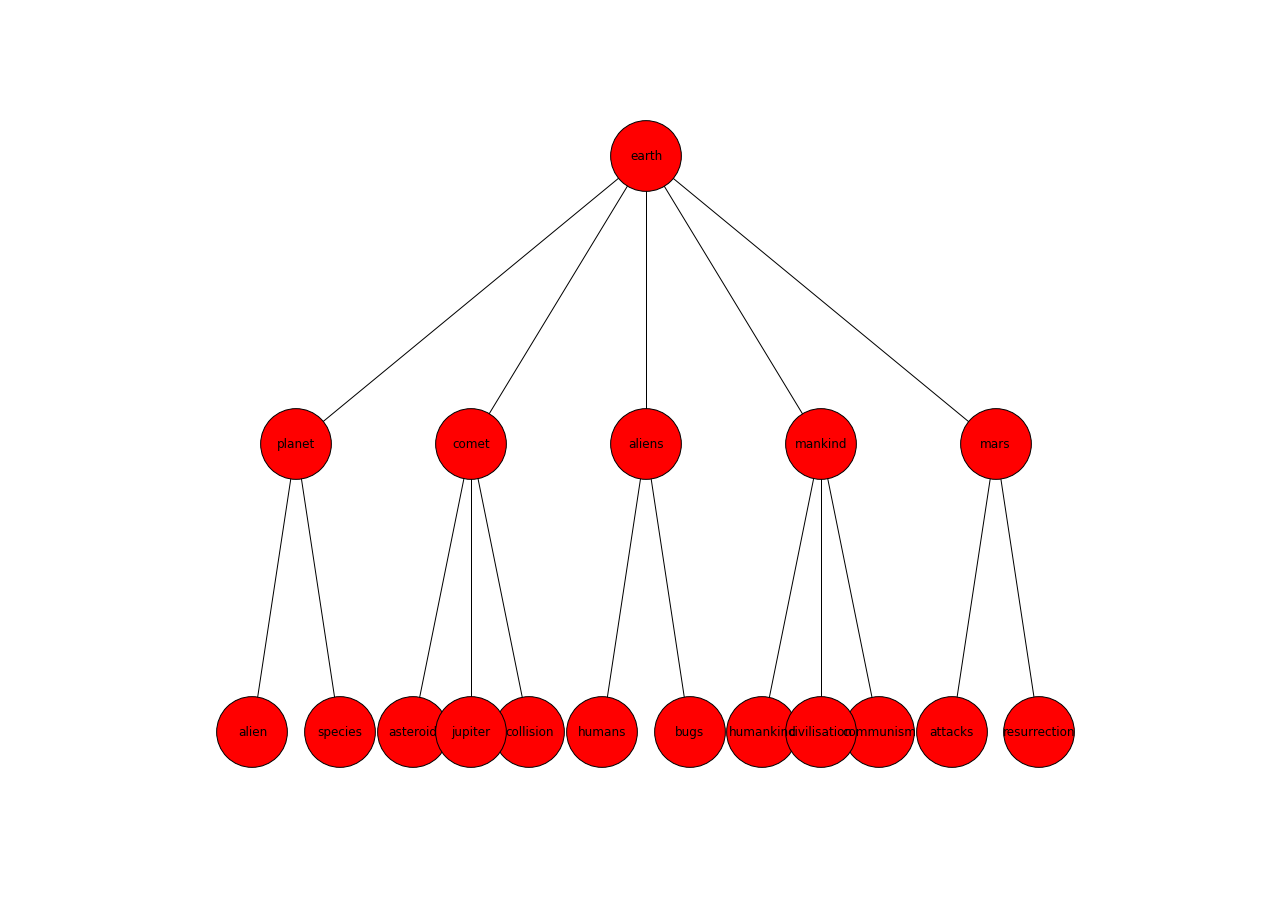

In [143]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Set plot size
plt.rcParams['figure.figsize'] = (17, 12)

# Recursive function allowing to draw a tree using NetworkX
def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, 
                  pos = None, parent = None):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
       pos: a dict saying where all nodes go if they have been assigned
       parent: parent of this branch.'''
    if pos == None:
        pos = {root:(xcenter,vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = G.neighbors(root)
    if parent != None:
        neighbors.remove(parent)
    if len(neighbors)!=0:
        dx = width/len(neighbors) 
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G,neighbor, width = dx, vert_gap = vert_gap, 
                                vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                parent = root)
    return pos

# Create a new graph instance
G=nx.Graph()

# Define the first 5 most similar words
main_word = 'earth'
top5 = model.most_similar(main_word, topn=5)
top5_words = map(lambda x: x[0], top5)
print top5_words

# To miss repetitions we will remind unique words
unique = [i for i in top5_words]
for word in top5_words:
    G.add_edge(main_word, word)
    for subword in model.most_similar(word, topn=3):
        if subword[0] not in unique and subword[0] != main_word:
            G.add_edge(word, subword[0])
            unique.append(subword[0])

        
pos = hierarchy_pos(G, main_word)    
nx.draw(G, pos=pos, with_labels=True, node_size=5000)

plt.show()